In [1]:
import os
import math
import cv2
import numpy as np
from skimage import io
import pickle
import seaborn as sns
import itertools

from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../../src/models")

from predict import CarCountingModel as Model

/opt/conda/envs/py3.6/lib/python3.6/site-packages/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


## Count cars on a test scene anyway..

In [2]:
model_path = "../../models/logs/model_iter_51331"
insize = 128
count_ignore_width=8
car_max = 14
class_num = car_max + 1

mean_path = "../../data/cowc_processed/train_val/crop/mean.npy"
mean = np.load(mean_path)

model = Model(model_path, class_num, insize, mean)

In [3]:
data_root = "../../data/cowc/datasets/ground_truth_sets"
city_dir = "Utah_AGRC"
scene = "12TVL240120"

scene_basename = os.path.join(os.path.join(data_root, city_dir), scene)

image_path = scene_basename + ".png"
label_path = scene_basename + "_Annotated_Cars.png"

In [4]:
mosaic_image = io.imread(image_path)[:, :, :3]
mosaic_label = io.imread(label_path)[:, :, 3]

print(mosaic_image.shape)
print(mosaic_label.shape)

(13333, 13333, 3)
(13333, 13333)


In [5]:
cars, grid_size = model.count_on_mosaic(mosaic_image, mosaic_label)
cars_counted, cars_labeled = cars

with open("cars_counted.pickle", 'wb') as handle:
    pickle.dump(cars_counted, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("cars_labeled.pickle", 'wb') as handle:
    pickle.dump(cars_labeled, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("grid_size.pickle", 'wb') as handle:
    pickle.dump(grid_size, handle, protocol=pickle.HIGHEST_PROTOCOL)

14400 / 14400


In [5]:
#with open("cars_counted.pickle", 'rb') as handle:
#  cars_counted = pickle.load(handle)

#with open("cars_labeled.pickle", 'rb') as handle:
#  cars_labeled = pickle.load(handle)

#with open("grid_size.pickle", 'rb') as handle:
#  grid_size = pickle.load(handle)

## Visualize counted cars distribution as a heatmap

In [6]:
def get_color_map(sns_palette):
    
    color_map = np.empty(shape=[0, 3], dtype=np.uint8)

    for color in sns_palette:
        r = int(color[0] * 255)
        g = int(color[1] * 255)
        b = int(color[2] * 255)
        rgb_byte = np.array([[r, g, b]], dtype=np.uint8)
        color_map = np.append(color_map, rgb_byte, axis=0)
    
    return color_map


def overlay_heatmap(
    cars, background_image, car_max, grid_size, cmap, 
    line_rgb=[0, 0, 0], line_thickness=6, alpha=0.5, min_car_to_show=1, background_rgb=[0, 0, 0]):
    
    yi_max, xi_max = cars.shape

    result = background_image.copy()
    heatmap = background_image.copy()

    sns_palette = sns.color_palette(cmap, n_colors=car_max + 1)
    color_map = get_color_map(sns_palette)
    
    for yi in range(yi_max):
        for xi in range(xi_max):
            
            top, left = yi * grid_size, xi * grid_size
            bottom, right = top + grid_size, left + grid_size
            
            cars_counted = cars[yi, xi]

            if cars_counted < min_car_to_show:
                if background_rgb is not None:
                    heatmap[top:bottom, left:right] = np.array(background_rgb)
            else:
                heatmap[top:bottom, left:right] = color_map[cars_counted]

                if line_thickness > 0:
                    cv2.rectangle(heatmap, (left, top), (right, bottom), line_rgb, thickness=line_thickness)
    
    cv2.addWeighted(heatmap, alpha, result, 1 - alpha, 0, result)

    return result

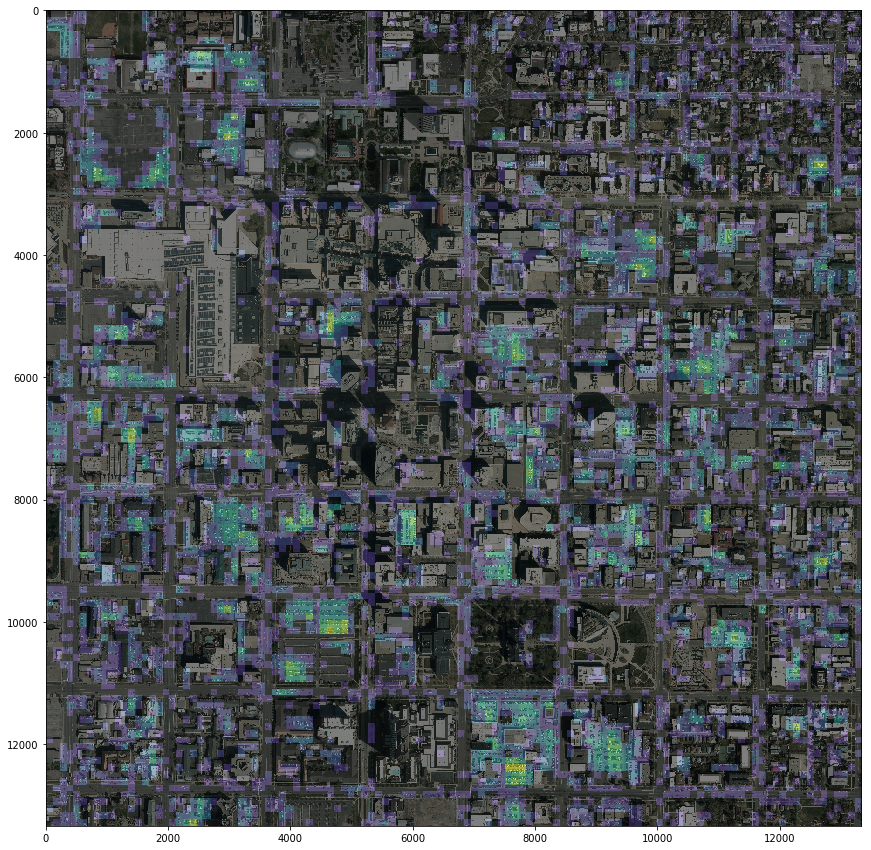

In [7]:
heatmap_overlayed = overlay_heatmap(cars_counted, mosaic_image, car_max, grid_size, cmap='viridis', line_thickness=-1)

fig = plt.figure(figsize=(15, 15))
plt.imshow(heatmap_overlayed)

## Show counted car number on the image

In [8]:
def plot_counts_on_heatmap(heatmap_overlayed, aoi_tblr, cars, grid_size, min_car_to_show=1, figsize=(15, 15)):
    
    top, bottom, left, right = aoi_tblr
    
    yi_min, xi_min = int(math.floor(top / grid_size)), int(math.floor(left / grid_size))
    yi_max, xi_max = int(math.ceil(bottom / grid_size)), int(math.ceil(right / grid_size))
    
    top, left, bottom, right = yi_min * grid_size, xi_min * grid_size, yi_max * grid_size, xi_max * grid_size
    
    fig = plt.figure(figsize=figsize)
    plt.imshow(heatmap_overlayed[top:bottom, left:right])
    
    for (yi, xi) in itertools.product(range(yi_min, yi_max), range(xi_min, xi_max)):
        
        car_num = cars[yi, xi]
        if car_num < min_car_to_show:
            continue
        
        plt.text(
            (xi + 0.5) * grid_size - left, (yi + 0.5) * grid_size - top, format(car_num, 'd'), 
            horizontalalignment="center", verticalalignment="center", color="black"
        )
    
    plt.show()

In [9]:
heatmap_overlayed_2 = overlay_heatmap(cars_counted, mosaic_image, car_max, grid_size, cmap='Reds')

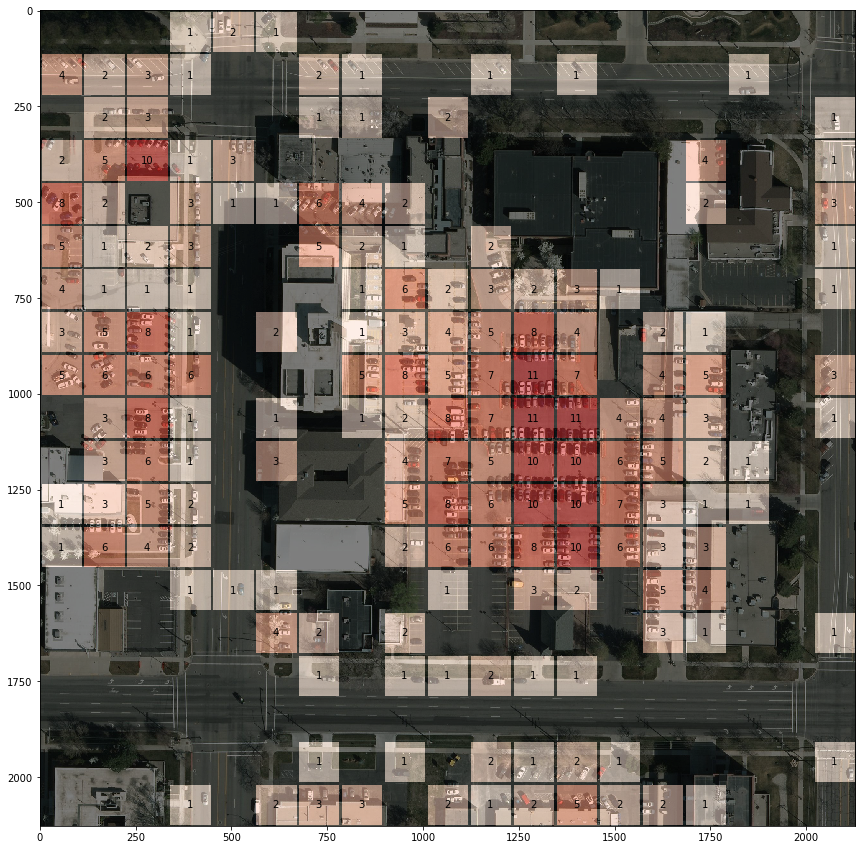

In [10]:
top, bottom, left, right = 11000, 13000, 8000, 10000
plot_counts_on_heatmap(heatmap_overlayed_2, (top, bottom, left, right), cars_counted, grid_size)

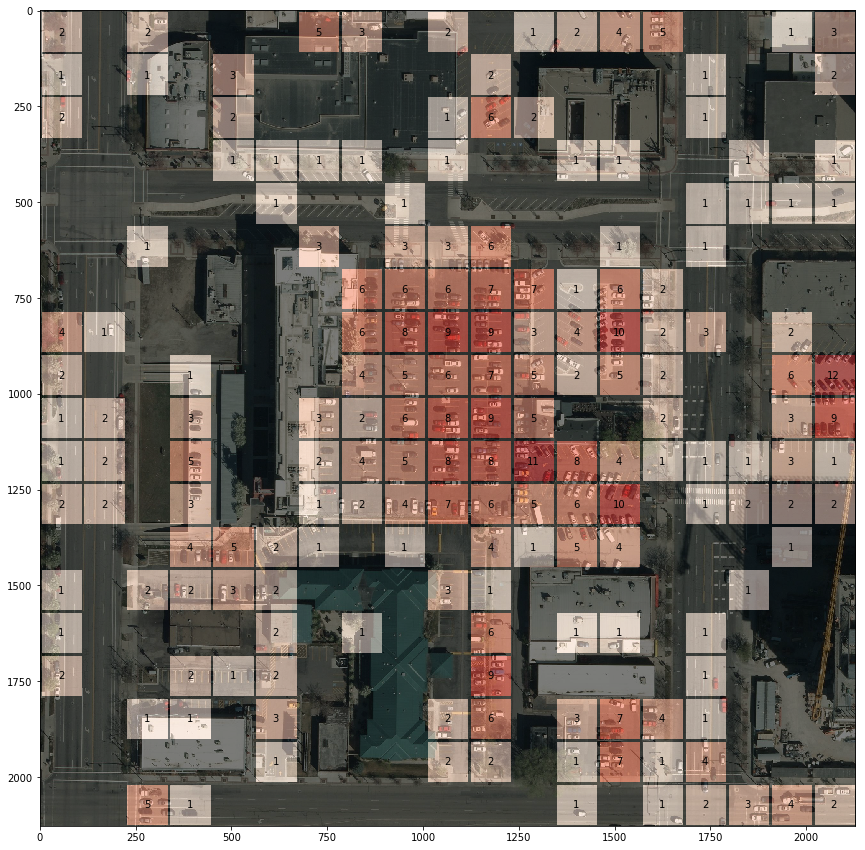

In [11]:
top, bottom, left, right = 7500, 9500, 2000, 4000
plot_counts_on_heatmap(heatmap_overlayed_2, (top, bottom, left, right), cars_counted, grid_size)

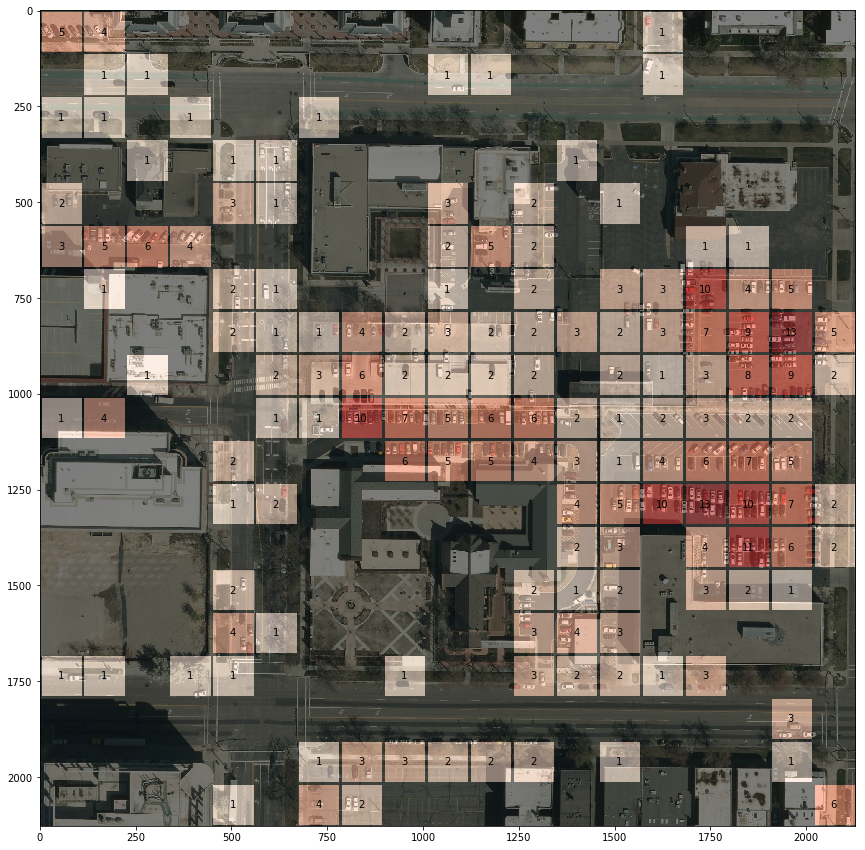

In [12]:
top, bottom, left, right = 3000, 5000, 8000, 10000
plot_counts_on_heatmap(heatmap_overlayed_2, (top, bottom, left, right), cars_counted, grid_size)